In [13]:
!pip3 install numpy
!pip3 install pandas
!pip3 install torch
!pip3 install scikit-learn
!pip3 install tensorflow
!pip3 install setuptools

# Data Processing

In [18]:
import json
from datetime import datetime

def merge_json_files(performance_file, record_file, output_file):
    with open(performance_file, 'r') as pf:
        performance_data = json.load(pf)

    with open(record_file, 'r') as rf:
        record_data = json.load(rf)
    
    record_data = [
        {**record, "timestamp": datetime.strptime(record["timestamp"], "%Y-%m-%dT%H:%M:%S.%fZ")}
        for record in record_data
    ]
    
    merged_data = []

    for perf_sample in performance_data:
        perf_timestamp = datetime.strptime(perf_sample["timestamp"], "%Y-%m-%dT%H:%M:%S.%fZ")

        closest_record = None
        min_diff = float('inf')

        for record in record_data:
            diff = abs((perf_timestamp - record["timestamp"]).total_seconds())
            if diff < min_diff:
                min_diff = diff
                closest_record = record

        if closest_record:
            merged_sample = {
                "timestamp": perf_sample["timestamp"],
                "requestPerSec": perf_sample["requestPerSec"],
                "bytesPerSec": perf_sample["bytesPerSec"],
                "bufferSize": perf_sample["bufferSize"],
                "cpuUsage": closest_record["cpuUsage"],
                "ramUsage": closest_record["ramUsage"]
            }
            merged_data.append(merged_sample)

    with open(output_file, 'w') as output:
        json.dump(merged_data, output, indent=4)

merge_json_files('performance.json', 'record.json', 'training_data.json')


KeyboardInterrupt: 

In [15]:
import json

def calculate_optimal_values(cpu_usage, ram_usage, request_per_sec, bytes_per_sec):
    max_cpu_usage = 80
    max_ram_usage = 80
    initial_message_size = 1024

    optimal_message_size = initial_message_size
    if cpu_usage > max_cpu_usage:
        optimal_message_size = initial_message_size // 2
    elif cpu_usage < 10:
        optimal_message_size = initial_message_size * 2
    
    if ram_usage > max_ram_usage:
        optimal_mps = max(100, request_per_sec // 2)
    else:
        optimal_mps = min(1000, request_per_sec * 2)
    
    return optimal_mps, optimal_message_size

def process_data(input_file, output_file):
    with open(input_file, 'r') as file:
        data = json.load(file)

    for sample in data:
        cpu_usage = sample.get("cpuUsage", 0)
        ram_usage = sample.get("ramUsage", 0)
        request_per_sec = sample.get("requestPerSec", 0)
        bytes_per_sec = sample.get("bytesPerSec", 0)

        optimal_mps, optimal_message_size = calculate_optimal_values(
            cpu_usage, ram_usage, request_per_sec, bytes_per_sec
        )

        sample["optimalMessagesPerSec"] = optimal_mps
        sample["optimalMessageSize"] = optimal_message_size

    with open(output_file, 'w') as file:
        json.dump(data, file, indent=4)

if __name__ == "__main__":
    input_file = "training_data.json"
    output_file = "data_final.json"
    process_data(input_file, output_file)
    print(f"Processing complete. The results have been saved to {output_file}.")


Processing complete. The results have been saved to data_final.json.


## Resource Optimization Model

In [16]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

def load_data(input_file):
    with open(input_file, 'r') as file:
        data = json.load(file)

    features = []
    targets_mps = []
    targets_size = []

    for sample in data:
        cpu_usage = sample.get("cpuUsage", 0)
        ram_usage = sample.get("ramUsage", 0)
        request_per_sec = sample.get("requestPerSec", 0)
        bytes_per_sec = sample.get("bytesPerSec", 0)
        optimal_mps = sample.get("optimalMessagesPerSec", 0)
        optimal_message_size = sample.get("optimalMessageSize", 0)

        features.append([cpu_usage, ram_usage, request_per_sec, bytes_per_sec])
        targets_mps.append(optimal_mps)
        targets_size.append(optimal_message_size)

    return np.array(features), np.array(targets_mps), np.array(targets_size)

def train_model(features, targets, target_name):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error for {target_name}: {mse}")

    return model

def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def main():
    input_file = "data_final.json"

    features, targets_mps, targets_size = load_data(input_file)

    print("Training model for optimalMessagesPerSec...")
    mps_model = train_model(features, targets_mps, "optimalMessagesPerSec")
    save_model(mps_model, "optimal_mps_model.pkl")

    print("Training model for optimalMessageSize...")
    size_model = train_model(features, targets_size, "optimalMessageSize")
    save_model(size_model, "optimal_size_model.pkl")

if __name__ == "__main__":
    main()


Training model for optimalMessagesPerSec...
Mean Squared Error for optimalMessagesPerSec: 0.0
Model saved to optimal_mps_model.pkl
Training model for optimalMessageSize...
Mean Squared Error for optimalMessageSize: 1348.9071282843895
Model saved to optimal_size_model.pkl


In [17]:
import joblib
import numpy as np

def predict_values(features):
    mps_model = joblib.load("optimal_mps_model.pkl")
    size_model = joblib.load("optimal_size_model.pkl")

    predicted_mps = mps_model.predict(features)
    predicted_size = size_model.predict(features)

    return predicted_mps, predicted_size

features = np.array([[5.0, 135.0, 150, 2048]])  # Example data: [cpuUsage, ramUsage, requestPerSec, bytesPerSec]
predicted_mps, predicted_size = predict_values(features)

print(f"Predicted optimalMessagesPerSec: {predicted_mps[0]}")
print(f"Predicted optimalMessageSize: {predicted_size[0]}")


Predicted optimalMessagesPerSec: 100.0
Predicted optimalMessageSize: 2048.0


## Throughput Optimization

In [13]:
import random 
import csv
class ThroughputDataGenerator(object):

    def __init__(self):
        self.samples = []

    def generate(self, samples_num=10000):

        message_bytes = 38  # Bytes per message
        ram_usage = 10
        cpu_usage = 0
        buffer_size = 0

        cpu_factor = 0.1
        ram_factor = 0.1

        for _ in range(samples_num):
            # Generate random inbound parameters
            request_per_sec = random.randint(40, 60)
            bytes_per_sec = request_per_sec * message_bytes

            # Outbound message parameters
            if buffer_size > 0 and random.random() > 0.5:  # Randomly determine if data is flushed
                outbound_message_per_sec = random.randint(1, 5) * request_per_sec
                outbound_message_size = random.randint(1, 3) * message_bytes
            else:
                outbound_message_per_sec = 0
                outbound_message_size = 0

            # Update buffer size
            buffer_decrement = outbound_message_size * outbound_message_per_sec
            buffer_size += bytes_per_sec - buffer_decrement
            buffer_size = max(0, buffer_size)  # Ensure buffer size does not go below 0

            # Update RAM usage
            ram_usage = buffer_size * ram_factor / 1000

            # Update CPU usage
            cpu_usage = ((request_per_sec * bytes_per_sec) + 
                         (outbound_message_size * outbound_message_per_sec) * cpu_factor) / 1000
            cpu_usage = min(100, cpu_usage)  # Cap CPU usage at 100

            # Adjust RAM usage further based on CPU usage
            ram_usage += cpu_usage * 0.1

            # Append sample to the list
            self.samples.append({
                "ram_usage": round(ram_usage, 2),
                "cpu_usage": round(cpu_usage, 2),
                "outbound_message_per_sec": outbound_message_per_sec,
                "outbound_message_size": outbound_message_size,
                "bytes_per_sec": bytes_per_sec,
                "request_per_sec": request_per_sec,
                "buffer_size": buffer_size
            })
    
    def export_to_csv(self, file_name="throughput_data.csv"):
        with open(file_name, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=self.samples[0].keys())
            writer.writeheader()
            writer.writerows(self.samples)
        print(f"Data exported to {file_name}")

generator = ThroughputDataGenerator()
generator.generate(10000)

for i in range(0, len(generator.samples)):
    print(generator.samples[i])



{'ram_usage': 10.2, 'cpu_usage': 100, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 2014, 'request_per_sec': 53, 'buffer_size': 2014}
{'ram_usage': 10.42, 'cpu_usage': 100, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 2166, 'request_per_sec': 57, 'buffer_size': 4180}
{'ram_usage': 7.64, 'cpu_usage': 73.9, 'outbound_message_per_sec': 88, 'outbound_message_size': 38, 'bytes_per_sec': 1672, 'request_per_sec': 44, 'buffer_size': 2508}
{'ram_usage': 10.47, 'cpu_usage': 100, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 2242, 'request_per_sec': 59, 'buffer_size': 4750}
{'ram_usage': 8.69, 'cpu_usage': 80.41, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 1748, 'request_per_sec': 46, 'buffer_size': 6498}
{'ram_usage': 10.0, 'cpu_usage': 100, 'outbound_message_per_sec': 174, 'outbound_message_size': 114, 'bytes_per_sec': 2204, 'request_per_sec': 58, 'buffer_size': 0}
{'ram_us

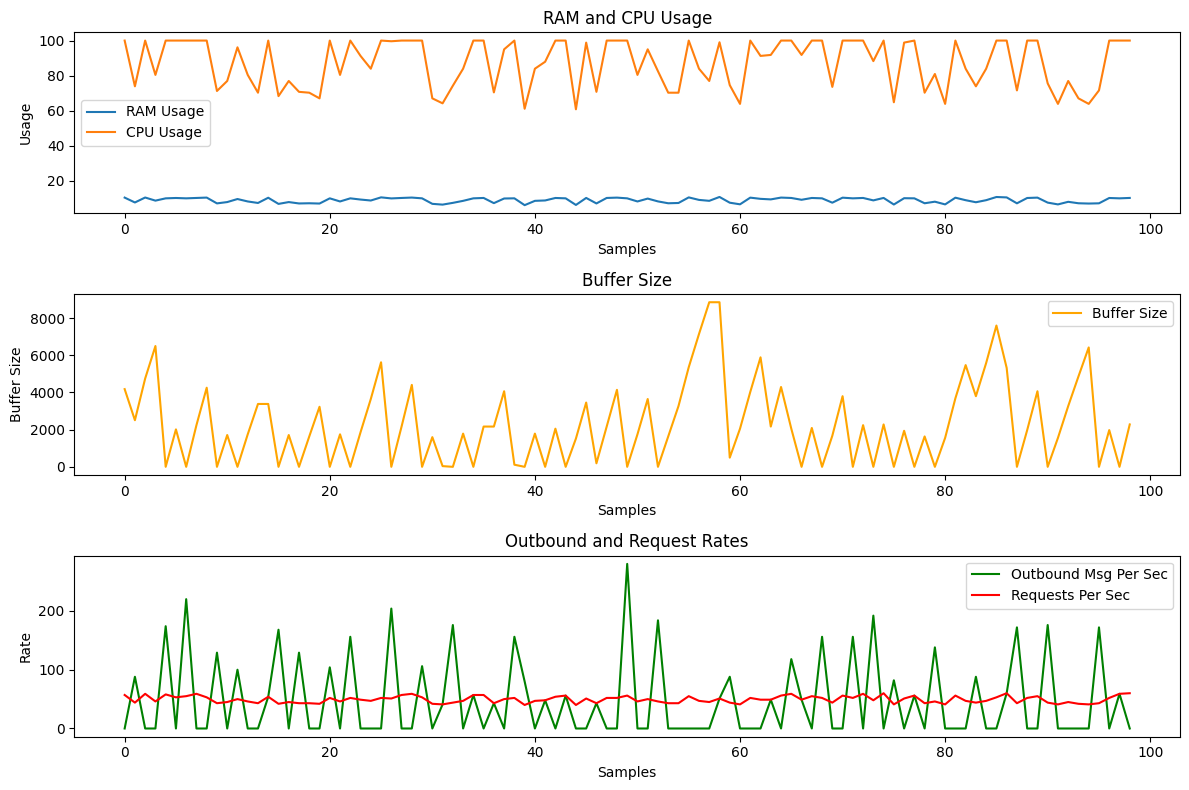

[{'ram_usage': 10.2, 'cpu_usage': 100, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 2014, 'request_per_sec': 53, 'buffer_size': 2014}, {'ram_usage': 10.42, 'cpu_usage': 100, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 2166, 'request_per_sec': 57, 'buffer_size': 4180}, {'ram_usage': 7.64, 'cpu_usage': 73.9, 'outbound_message_per_sec': 88, 'outbound_message_size': 38, 'bytes_per_sec': 1672, 'request_per_sec': 44, 'buffer_size': 2508}, {'ram_usage': 10.47, 'cpu_usage': 100, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 2242, 'request_per_sec': 59, 'buffer_size': 4750}, {'ram_usage': 8.69, 'cpu_usage': 80.41, 'outbound_message_per_sec': 0, 'outbound_message_size': 0, 'bytes_per_sec': 1748, 'request_per_sec': 46, 'buffer_size': 6498}, {'ram_usage': 10.0, 'cpu_usage': 100, 'outbound_message_per_sec': 174, 'outbound_message_size': 114, 'bytes_per_sec': 2204, 'request_per_sec': 58, 'buffer_size': 0}, {

In [14]:
import matplotlib.pyplot as plt

ram_usages = [sample["ram_usage"] for sample in generator.samples[1:100]]
cpu_usages = [sample["cpu_usage"] for sample in generator.samples[1:100]]
buffer_sizes = [sample["buffer_size"] for sample in generator.samples[1:100]]
outbound_message_per_secs = [sample["outbound_message_per_sec"] for sample in generator.samples[1:100]]
requests_per_sec = [sample["request_per_sec"] for sample in generator.samples[1:100]]


plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ram_usages, label="RAM Usage")
plt.plot(cpu_usages, label="CPU Usage")
plt.title("RAM and CPU Usage")
plt.xlabel("Samples")
plt.ylabel("Usage")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(buffer_sizes, label="Buffer Size", color="orange")
plt.title("Buffer Size")
plt.xlabel("Samples")
plt.ylabel("Buffer Size")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(outbound_message_per_secs, label="Outbound Msg Per Sec", color="green")
plt.plot(requests_per_sec, label="Requests Per Sec", color="red")
plt.title("Outbound and Request Rates")
plt.xlabel("Samples")
plt.ylabel("Rate")
plt.legend()

plt.tight_layout()
plt.show()

print(generator.samples[:10])  # Print the first 10 samples


In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare data for training
data = generator.samples




# Convert data to pandas DataFrame
df = pd.DataFrame(data)

# Step 3: Preprocess the data

# Define features and target variables
features = ['ram_usage', 'cpu_usage', 'bytes_per_sec', 'request_per_sec', 'buffer_size']
target_message_per_sec = 'outbound_message_per_sec'
target_message_size = 'outbound_message_size'

# Select features and targets for model 1 (outbound_message_per_sec)
X = df[features]
y_message_per_sec = df[target_message_per_sec]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_message_per_sec, test_size=0.2, random_state=42)

# Standardize the features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a RandomForest model for outbound_message_per_sec
rf_model_message_per_sec = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model_message_per_sec.fit(X_train_scaled, y_train)

# Make predictions
y_pred_message_per_sec = rf_model_message_per_sec.predict(X_test_scaled)

# Evaluate the model
mse_message_per_sec = mean_squared_error(y_test, y_pred_message_per_sec)
print(f"Mean Squared Error for outbound_message_per_sec: {mse_message_per_sec}")






Mean Squared Error for outbound_message_per_sec: 1273.8178336761266


In [16]:

# Step 5: Train a RandomForest model for outbound_message_size (same process)

# Select target for message size
y_message_size = df[target_message_size]

# Split data for message size prediction
y_train_size, y_test_size = train_test_split(y_message_size, test_size=0.2, random_state=42)

# Train the model for outbound_message_size
rf_model_message_size = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model_message_size.fit(X_train_scaled, y_train_size)

# Make predictions
y_pred_message_size = rf_model_message_size.predict(X_test_scaled)

# Evaluate the model
mse_message_size = mean_squared_error(y_test_size, y_pred_message_size)
print(f"Mean Squared Error for outbound_message_size: {mse_message_size}")

Mean Squared Error for outbound_message_size: 323.4828906955493


In [34]:
# Sample new data point (same structure as the input data)
new_data = {'ram_usage': 94, 'cpu_usage': 40, 'bytes_per_sec': 2530, 'request_per_sec': 57, 'buffer_size': 50400}
new_data_df = pd.DataFrame([new_data])

# Scale the new data (using the same scaler)
new_data_scaled = scaler.transform(new_data_df[features])

# Predict with both models
predicted_message_per_sec = rf_model_message_per_sec.predict(new_data_scaled)
predicted_message_size = rf_model_message_size.predict(new_data_scaled)

print(f"Predicted Outbound Message Per Sec: {predicted_message_per_sec[0]}")
print(f"Predicted Outbound Message Size: {predicted_message_size[0]}")


Predicted Outbound Message Per Sec: 7.366
Predicted Outbound Message Size: 2.394


In [37]:
import joblib

# Save the model to a file
joblib.dump(rf_model_message_size, 'random_forest_message_size.pkl')



['random_forest_message_size.pkl']

In [36]:
joblib.dump(rf_model_message_per_sec, 'random_forest_message_per_sec.pkl')

['random_forest_message_per_sec.pkl']